In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
#%matplotlib widget

In [9]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42);

# Synthethic toy dataset

Let us consider the function:

$$f : \mathbb{R}^2 \rightarrow \mathbb{R}; \qquad x \rightarrow 2\sin (x_1) - 3\cos (x_2)$$

restricted to the box range:

\begin{equation}
x_1 \in [-2, 2], x_2 \in [-2, 2].
\end{equation}


We have a training and a test datasets with 500 samples each, uniformly sampled within the domain. Samples are corrupted with an additive Gaussian noise with standard deviation $\sigma_e = 0.1$

We reconstruct the function using a MLP characterized by
* 2 input channels and 1 input channel - not a choice, this is the structure of $f(x)$: 
* 2 hidden layers
* 16 neurons in the first hidden layer, 8 neurons in the second hidden layer
* $\tanh$ activation function 

In [10]:
# Constants

n_x = 2 # number of inputs
n_y = 1 # number of outputs
a = -2.0 # lower bound x_1/x_2
b = 2.0 # upper bound x_1/x_2
n_samples = 500 # number of samples in the training/test datasets
sigma_e = 0.1 # standard deviation of the noise
grid_points = 100 # number of points in the grid for the plot

In [11]:
# Function definition

def f(x):
    return 2*torch.sin(x[..., 0])  - 3*torch.cos(x[..., 1]) # ellipses used to handle an optional "batch" dimension
# f(torch.tensor([0.2, 0.4])), 2*np.sin(0.2) - 3*np.cos(0.4) # test

In [12]:
# Generate synthetic data

x1_train = a + torch.rand(n_samples)*(b - a)
x2_train = a + torch.rand(n_samples)*(b - a)
X_train = torch.stack([x1_train, x2_train], dim=-1)

y_train = f(X_train) + sigma_e * torch.randn(n_samples)
y_train = y_train.view(-1, 1)
X_train.shape, y_train.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

In [13]:
x1_test = a + torch.rand(n_samples)*(b - a)
x2_test = a + torch.rand(n_samples)*(b - a)
X_test = torch.stack([x1_test, x2_test], dim=-1)

y_test = f(X_test) + sigma_e * torch.randn(n_samples)
y_test = y_test.view(-1, 1)
X_test.shape, y_test.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

## Dataset visualization

Let us visualize the true function together with the noisy training points.

Note that visualizing the true function would be impossible in real-world problems and impractical higher dimensions.

In [14]:


x1_grid = np.linspace(a, b, grid_points)
x2_grid = np.linspace(a, b, grid_points)
X1_mesh, X2_mesh = np.meshgrid(x1_grid, x2_grid)
X_grid = torch.tensor(np.c_[X1_mesh.ravel(), X2_mesh.ravel()], dtype=torch.float32)
y_grid = f(X_grid)

In [15]:
X1_mesh.shape, X2_mesh.shape, 

((100, 100), (100, 100))

In [16]:
X_grid.shape, y_grid.shape

(torch.Size([10000, 2]), torch.Size([10000]))

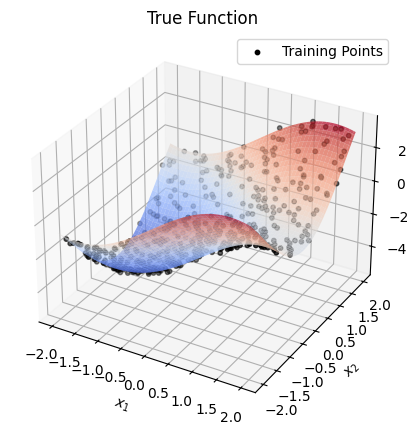

In [17]:
# 3D Plot of True Function
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_mesh, X2_mesh, y_grid.view(100, 100).numpy(), cmap='coolwarm', alpha=0.7)#, edgecolor='none')
ax1.set_title("True Function")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(), y_train[:, 0].numpy(), color='k', s=10, label='Training Points')
ax1.legend()
ax1.set_zlabel("$y$")
plt.show()

Let us define a feed-forward (FF) neural network, a.k.a. multi-layer perceptron (MLP)

## Feed-forward model training

In [18]:
# Define a simple neural network

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(n_x, 16) 
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(16, 8)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(8, n_y)

    def forward(self, x):
        x = self.act1(self.fc1(x)) # 16
        x = self.act2(self.fc2(x)) # 8
        x = self.fc3(x) # 1
        return x

model = FeedForwardNN()

In [ ]:
# The standard MLP is has a simple sequential structure. There is a shortcut to define it in PyTorch!

# model = nn.Sequential(
#     nn.Linear(2, 16),
#     nn.ReLU(),
#     nn.Linear(16, 8), 
#     nn.Linear(8, 1)
# )

Let us train the MLP

In [19]:
# Optimization loop

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
iters = 5000
LOSS = []
for iter in range(iters):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    LOSS.append(loss.item())
    if iter % 100 == 0:
        print(f"Epoch {iter}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 5.6992
Epoch 100: Loss = 2.5214
Epoch 200: Loss = 1.6478
Epoch 300: Loss = 1.1072
Epoch 400: Loss = 0.6010
Epoch 500: Loss = 0.2862
Epoch 600: Loss = 0.1569
Epoch 700: Loss = 0.1041
Epoch 800: Loss = 0.0775
Epoch 900: Loss = 0.0615
Epoch 1000: Loss = 0.0508
Epoch 1100: Loss = 0.0434
Epoch 1200: Loss = 0.0380
Epoch 1300: Loss = 0.0340
Epoch 1400: Loss = 0.0309
Epoch 1500: Loss = 0.0285
Epoch 1600: Loss = 0.0265
Epoch 1700: Loss = 0.0249
Epoch 1800: Loss = 0.0235
Epoch 1900: Loss = 0.0223
Epoch 2000: Loss = 0.0213
Epoch 2100: Loss = 0.0203
Epoch 2200: Loss = 0.0194
Epoch 2300: Loss = 0.0186
Epoch 2400: Loss = 0.0178
Epoch 2500: Loss = 0.0171
Epoch 2600: Loss = 0.0164
Epoch 2700: Loss = 0.0158
Epoch 2800: Loss = 0.0152
Epoch 2900: Loss = 0.0147
Epoch 3000: Loss = 0.0142
Epoch 3100: Loss = 0.0138
Epoch 3200: Loss = 0.0135
Epoch 3300: Loss = 0.0131
Epoch 3400: Loss = 0.0128
Epoch 3500: Loss = 0.0126
Epoch 3600: Loss = 0.0123
Epoch 3700: Loss = 0.0121
Epoch 3800: Loss = 0.011

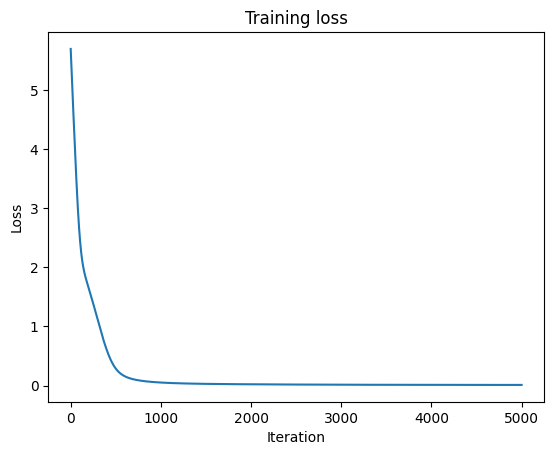

In [20]:
plt.figure()
plt.plot(LOSS)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss');

## Model evaluation

In [21]:
# Visualization
with torch.no_grad():
    y_pred_test = model(X_test)

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_21900\4065299676.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.hist(y_test.numpy() - y_pred_test.numpy(), label="$y - \hat{y}$")


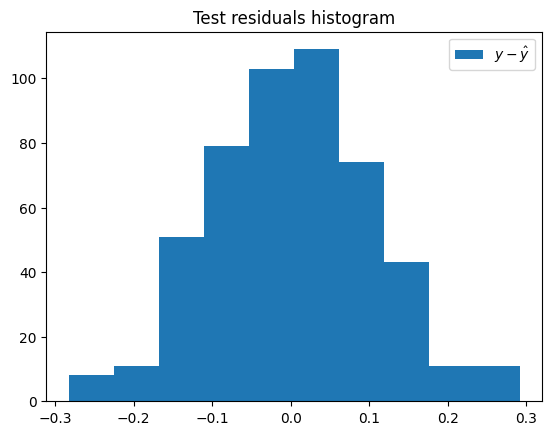

In [22]:
plt.figure()
plt.title("Test residuals histogram", )
plt.hist(y_test.numpy() - y_pred_test.numpy(), label="$y - \hat{y}$")
plt.legend();

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_21900\147285588.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(y_test, y_pred_test, 'o', label='Predicted $\hat y$', zorder=1)
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_21900\147285588.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(y_test, y_test - y_pred_test, 'ro', label='Residual $y - \hat{y}$', zorder=0)


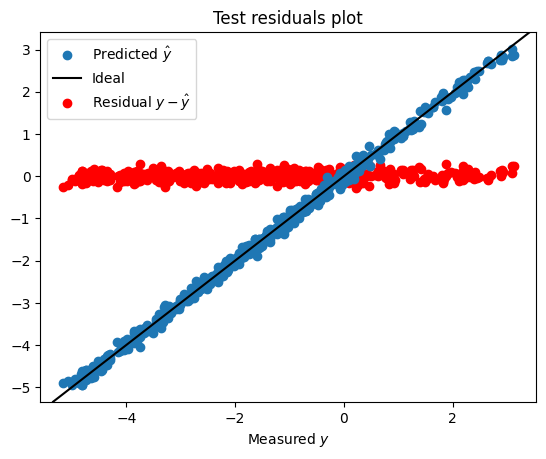

In [23]:
plt.figure()
plt.title('Test residuals plot')
plt.plot(y_test, y_pred_test, 'o', label='Predicted $\hat y$', zorder=1)
plt.axline((1, 1), slope=1, color="k", label="Ideal", zorder=2) # the ideal diagonal prediction
plt.plot(y_test, y_test - y_pred_test, 'ro', label='Residual $y - \hat{y}$', zorder=0)
plt.legend()
plt.xlabel('Measured $y$');

In [25]:
with torch.no_grad():
    y_true_grid = f(X_grid)
    y_pred_grid = model(X_grid).squeeze(-1)

y_true_grid.shape, y_pred_grid.shape

(torch.Size([10000]), torch.Size([10000]))

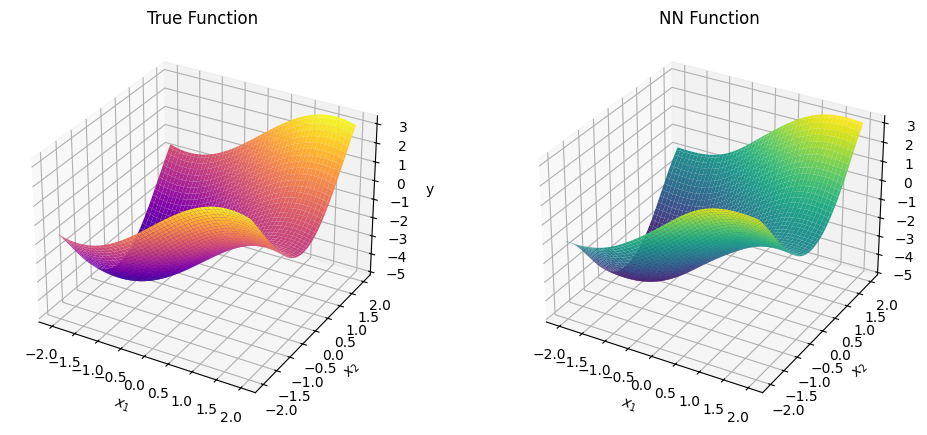

In [31]:
# 3D Plot of True Function
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_mesh, X2_mesh, y_grid.view(grid_points, grid_points), cmap='plasma', edgecolor='none')
ax1.set_title("True Function")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("y")

# 3D Plot of NN Predictions
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_mesh, X2_mesh, y_pred_grid.view(grid_points, grid_points), cmap='viridis', edgecolor='none') # cmap = 'jet'
ax2.set_title("NN Function")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("y");

## Training with mini-batches

In [ ]:
# Optimization loop with mini-batches

model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
iters = 5000
batch_size = 64
LOSS = []
for iter in range(iters):
    optimizer.zero_grad()
    batch_idx = np.random.randint(0, len(X_train), batch_size)
    y_pred = model(X_train[batch_idx])
    loss = criterion(y_pred, y_train[batch_idx])
    loss.backward()
    optimizer.step()

    LOSS.append(loss.item())
    if iter % 100 == 0:
        print(f"Epoch {iter}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 6.8003
Epoch 100: Loss = 2.9544
Epoch 200: Loss = 1.5331
Epoch 300: Loss = 1.0174
Epoch 400: Loss = 0.4971
Epoch 500: Loss = 0.3461
Epoch 600: Loss = 0.1756
Epoch 700: Loss = 0.0946
Epoch 800: Loss = 0.0767
Epoch 900: Loss = 0.1367
Epoch 1000: Loss = 0.0532
Epoch 1100: Loss = 0.0608
Epoch 1200: Loss = 0.0436
Epoch 1300: Loss = 0.0416
Epoch 1400: Loss = 0.0302
Epoch 1500: Loss = 0.0357
Epoch 1600: Loss = 0.0321
Epoch 1700: Loss = 0.0308
Epoch 1800: Loss = 0.0310
Epoch 1900: Loss = 0.0310
Epoch 2000: Loss = 0.0288
Epoch 2100: Loss = 0.0270
Epoch 2200: Loss = 0.0281
Epoch 2300: Loss = 0.0218
Epoch 2400: Loss = 0.0206
Epoch 2500: Loss = 0.0217
Epoch 2600: Loss = 0.0173
Epoch 2700: Loss = 0.0135
Epoch 2800: Loss = 0.0148
Epoch 2900: Loss = 0.0167
Epoch 3000: Loss = 0.0174
Epoch 3100: Loss = 0.0087
Epoch 3200: Loss = 0.0202
Epoch 3300: Loss = 0.0137
Epoch 3400: Loss = 0.0160
Epoch 3500: Loss = 0.0141
Epoch 3600: Loss = 0.0224
Epoch 3700: Loss = 0.0119
Epoch 3800: Loss = 0.015

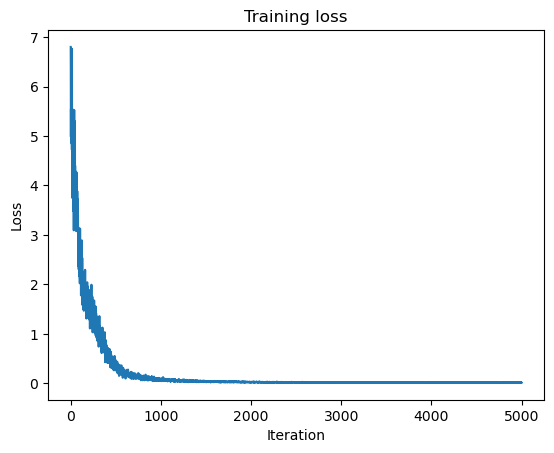

In [ ]:
plt.figure()
plt.plot(LOSS)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss');

With mini-batches the single optimization iteration is computationally lighter, but noisier. There is a trade-off